### Load Libraries

In [257]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.feature_selection import RFECV

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelBinarizer

import pickle

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from tensorflow.keras.utils import to_categorical
from iteration_utilities import deepflatten
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier

### Data collection

In [1]:
dataframe = pd.read_csv('Covid Data.csv')
#showing our initial dataframe here
dataframe

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,13,2,1,9999-99-99,97,2,40,97,2,...,2,2,2,2,2,2,2,2,7,97
1048571,1,13,2,2,9999-99-99,2,2,51,97,2,...,2,2,1,2,2,2,2,2,7,2
1048572,2,13,2,1,9999-99-99,97,2,55,97,2,...,2,2,2,2,2,2,2,2,7,97
1048573,2,13,2,1,9999-99-99,97,2,28,97,2,...,2,2,2,2,2,2,2,2,7,97


### Convert Boolean value

In [2]:
unmodified = dataframe.copy()

df = pd.read_excel('data_dictionary.xlsx')
dictionary = df.set_index('variable').T.to_dict()

for key, value in dictionary.items():
    for i in value.values():
        res = dict(item.split("=") for item in i.split(", "))
        dictionary[key] = res

dictionary = {outer_k.upper(): {inner_k.replace(' ', ''): inner_v for inner_k, inner_v in outer_v.items()} 
              for outer_k, outer_v in dictionary.items()}

for key, value in dictionary.items():
    dataframe[key]= dataframe[key].astype(str)
    dataframe.replace({key: dictionary[key]}, inplace=True)
    
dataframe

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,Female,NO,03/05/2020,UNKNOWN,YES,65,NO,NO,...,NO,NO,YES,NO,NO,NO,NO,NO,3,UNKNOWN
1,2,1,Male,NO,03/06/2020,UNKNOWN,YES,72,UNKNOWN,NO,...,NO,NO,YES,NO,NO,YES,YES,NO,5,UNKNOWN
2,2,1,Male,YES,09/06/2020,YES,NO,55,UNKNOWN,YES,...,NO,NO,NO,NO,NO,NO,NO,NO,3,NO
3,2,1,Female,NO,12/06/2020,UNKNOWN,NO,53,NO,NO,...,NO,NO,NO,NO,NO,NO,NO,NO,7,UNKNOWN
4,2,1,Male,NO,21/06/2020,UNKNOWN,NO,68,UNKNOWN,YES,...,NO,NO,YES,NO,NO,NO,NO,NO,3,UNKNOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,13,Male,NO,9999-99-99,UNKNOWN,NO,40,UNKNOWN,NO,...,NO,NO,NO,NO,NO,NO,NO,NO,7,UNKNOWN
1048571,1,13,Male,YES,9999-99-99,NO,NO,51,UNKNOWN,NO,...,NO,NO,YES,NO,NO,NO,NO,NO,7,NO
1048572,2,13,Male,NO,9999-99-99,UNKNOWN,NO,55,UNKNOWN,NO,...,NO,NO,NO,NO,NO,NO,NO,NO,7,UNKNOWN
1048573,2,13,Male,NO,9999-99-99,UNKNOWN,NO,28,UNKNOWN,NO,...,NO,NO,NO,NO,NO,NO,NO,NO,7,UNKNOWN


In [3]:
dataframe['DEATH'] = np.where(dataframe['DATE_DIED'] == '9999-99-99', 'NO', 'YES')

In [4]:
dataframe.rename(columns = {'PATIENT_TYPE':'HOSPITALIZED', 'HIPERTENSION':'HYPERTENSION'}, inplace = True)

In [5]:
dataframe['CLASIFFICATION_FINAL'].values[dataframe['CLASIFFICATION_FINAL'].values > 3] = 0

In [6]:
#saving the dataframe
pd.DataFrame.to_csv(dataframe, 'dataset.csv',index=False)

### One hot encoding

In [17]:
df1 = pd.read_csv('dataset.csv')
df1

,USMER,MEDICAL_UNIT,SEX,HOSPITALIZED,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,INMSUPR,HYPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,DEATH
0,2,1,Female,NO,03/05/2020,UNKNOWN,YES,65,NO,NO,...,NO,YES,NO,NO,NO,NO,NO,3,UNKNOWN,YES
1,2,1,Male,NO,03/06/2020,UNKNOWN,YES,72,UNKNOWN,NO,...,NO,YES,NO,NO,YES,YES,NO,0,UNKNOWN,YES
2,2,1,Male,YES,09/06/2020,YES,NO,55,UNKNOWN,YES,...,NO,NO,NO,NO,NO,NO,NO,3,NO,YES
3,2,1,Female,NO,12/06/2020,UNKNOWN,NO,53,NO,NO,...,NO,NO,NO,NO,NO,NO,NO,0,UNKNOWN,YES
4,2,1,Male,NO,21/06/2020,UNKNOWN,NO,68,UNKNOWN,YES,...,NO,YES,NO,NO,NO,NO,NO,3,UNKNOWN,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,13,Male,NO,9999-99-99,UNKNOWN,NO,40,UNKNOWN,NO,...,NO,NO,NO,NO,NO,NO,NO,0,UNKNOWN,NO
1048571,1,13,Male,YES,9999-99-99,NO,NO,51,UNKNOWN,NO,...,NO,YES,NO,NO,NO,NO,NO,0,NO,NO
1048572,2,13,Male,NO,9999-99-99,UNKNOWN,NO,55,UNKNOWN,NO,...,NO,NO,NO,NO,NO,NO,NO,0,UNKNOWN,NO
1048573,2,13,Male,NO,9999-99-99,UNKNOWN,NO,28,UNKNOWN,NO,...,NO,NO,NO,NO,NO,NO,NO,0,UNKNOWN,NO


In [18]:
df1.dtypes

USMER                    int64
MEDICAL_UNIT             int64
SEX                     object
HOSPITALIZED            object
DATE_DIED               object
INTUBED                 object
PNEUMONIA               object
AGE                      int64
PREGNANT                object
DIABETES                object
COPD                    object
ASTHMA                  object
INMSUPR                 object
HYPERTENSION            object
OTHER_DISEASE           object
CARDIOVASCULAR          object
OBESITY                 object
RENAL_CHRONIC           object
TOBACCO                 object
CLASIFFICATION_FINAL     int64
ICU                     object
DEATH                   object
dtype: object

In [19]:
df1['CLASIFFICATION_FINAL'].value_counts()

0    656596
3    381527
1      8601
2      1851
Name: CLASIFFICATION_FINAL, dtype: int64

In [20]:
df1.shape

(1048575, 22)

In [21]:
df1.drop(['DATE_DIED'], axis=1, inplace=True)
df1.shape

(1048575, 21)

In [22]:
df1.dtypes

USMER                    int64
MEDICAL_UNIT             int64
SEX                     object
HOSPITALIZED            object
INTUBED                 object
PNEUMONIA               object
AGE                      int64
PREGNANT                object
DIABETES                object
COPD                    object
ASTHMA                  object
INMSUPR                 object
HYPERTENSION            object
OTHER_DISEASE           object
CARDIOVASCULAR          object
OBESITY                 object
RENAL_CHRONIC           object
TOBACCO                 object
CLASIFFICATION_FINAL     int64
ICU                     object
DEATH                   object
dtype: object

In [23]:
col_list = [col for col in df1.columns.tolist() if df1[col].dtype.name == "object"]
df_oh = df1[col_list]
df1 = df1.drop(col_list, 1)
df_oh = pd.get_dummies(df_oh)
df1 = pd.concat([df1, df_oh], axis=1)
df1.head()

,USMER,MEDICAL_UNIT,AGE,CLASIFFICATION_FINAL,SEX_ Female,SEX_ Male,HOSPITALIZED_ NO,HOSPITALIZED_YES,INTUBED_NO,INTUBED_UNKNOWN,...,RENAL_CHRONIC_UNKNOWN,RENAL_CHRONIC_YES,TOBACCO_NO,TOBACCO_UNKNOWN,TOBACCO_YES,ICU_NO,ICU_UNKNOWN,ICU_YES,DEATH_NO,DEATH_YES
0,2,1,65,3,1,0,1,0,0,1,...,0,0,1,0,0,0,1,0,0,1
1,2,1,72,0,0,1,1,0,0,1,...,0,1,1,0,0,0,1,0,0,1
2,2,1,55,3,0,1,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1
3,2,1,53,0,1,0,1,0,0,1,...,0,0,1,0,0,0,1,0,0,1
4,2,1,68,3,0,1,1,0,0,1,...,0,0,1,0,0,0,1,0,0,1


In [24]:
y = df1.CLASIFFICATION_FINAL
X = df1.drop("CLASIFFICATION_FINAL", 1)
colnames = X.columns
pd.DataFrame.to_csv(df1, 'cleaned.csv')

### Recursive Feature Elimination

In [16]:
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [26]:
rf = RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_depth=5, n_estimators=100)
rf.fit(X, y)
rfe = RFECV(rf, min_features_to_select = 1, cv = 3, verbose=2)

In [27]:
rfe.fit(X, y)

Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 fe

RFECV(cv=3,
      estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                       n_jobs=-1),
      verbose=2)

In [28]:
rfe_score = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)
rfe_score = pd.DataFrame(list(rfe_score.items()), columns=['Features', 'Score'])
rfe_score = rfe_score.sort_values("Score", ascending = False)

In [29]:
print('---------Top 20----------')
rfe_top20 = rfe_score.head(20)
display(rfe_top20)
pd.DataFrame.to_csv(rfe_top20, 'RFE_Top20.csv')

---------Top 20----------


,Features,Score
49,DEATH_NO,1.00
50,DEATH_YES,0.98
1,MEDICAL_UNIT,0.96
6,HOSPITALIZED_YES,0.94
47,ICU_UNKNOWN,0.92
5,HOSPITALIZED_ NO,0.90
8,INTUBED_UNKNOWN,0.88
2,AGE,0.86
46,ICU_NO,0.84
0,USMER,0.82


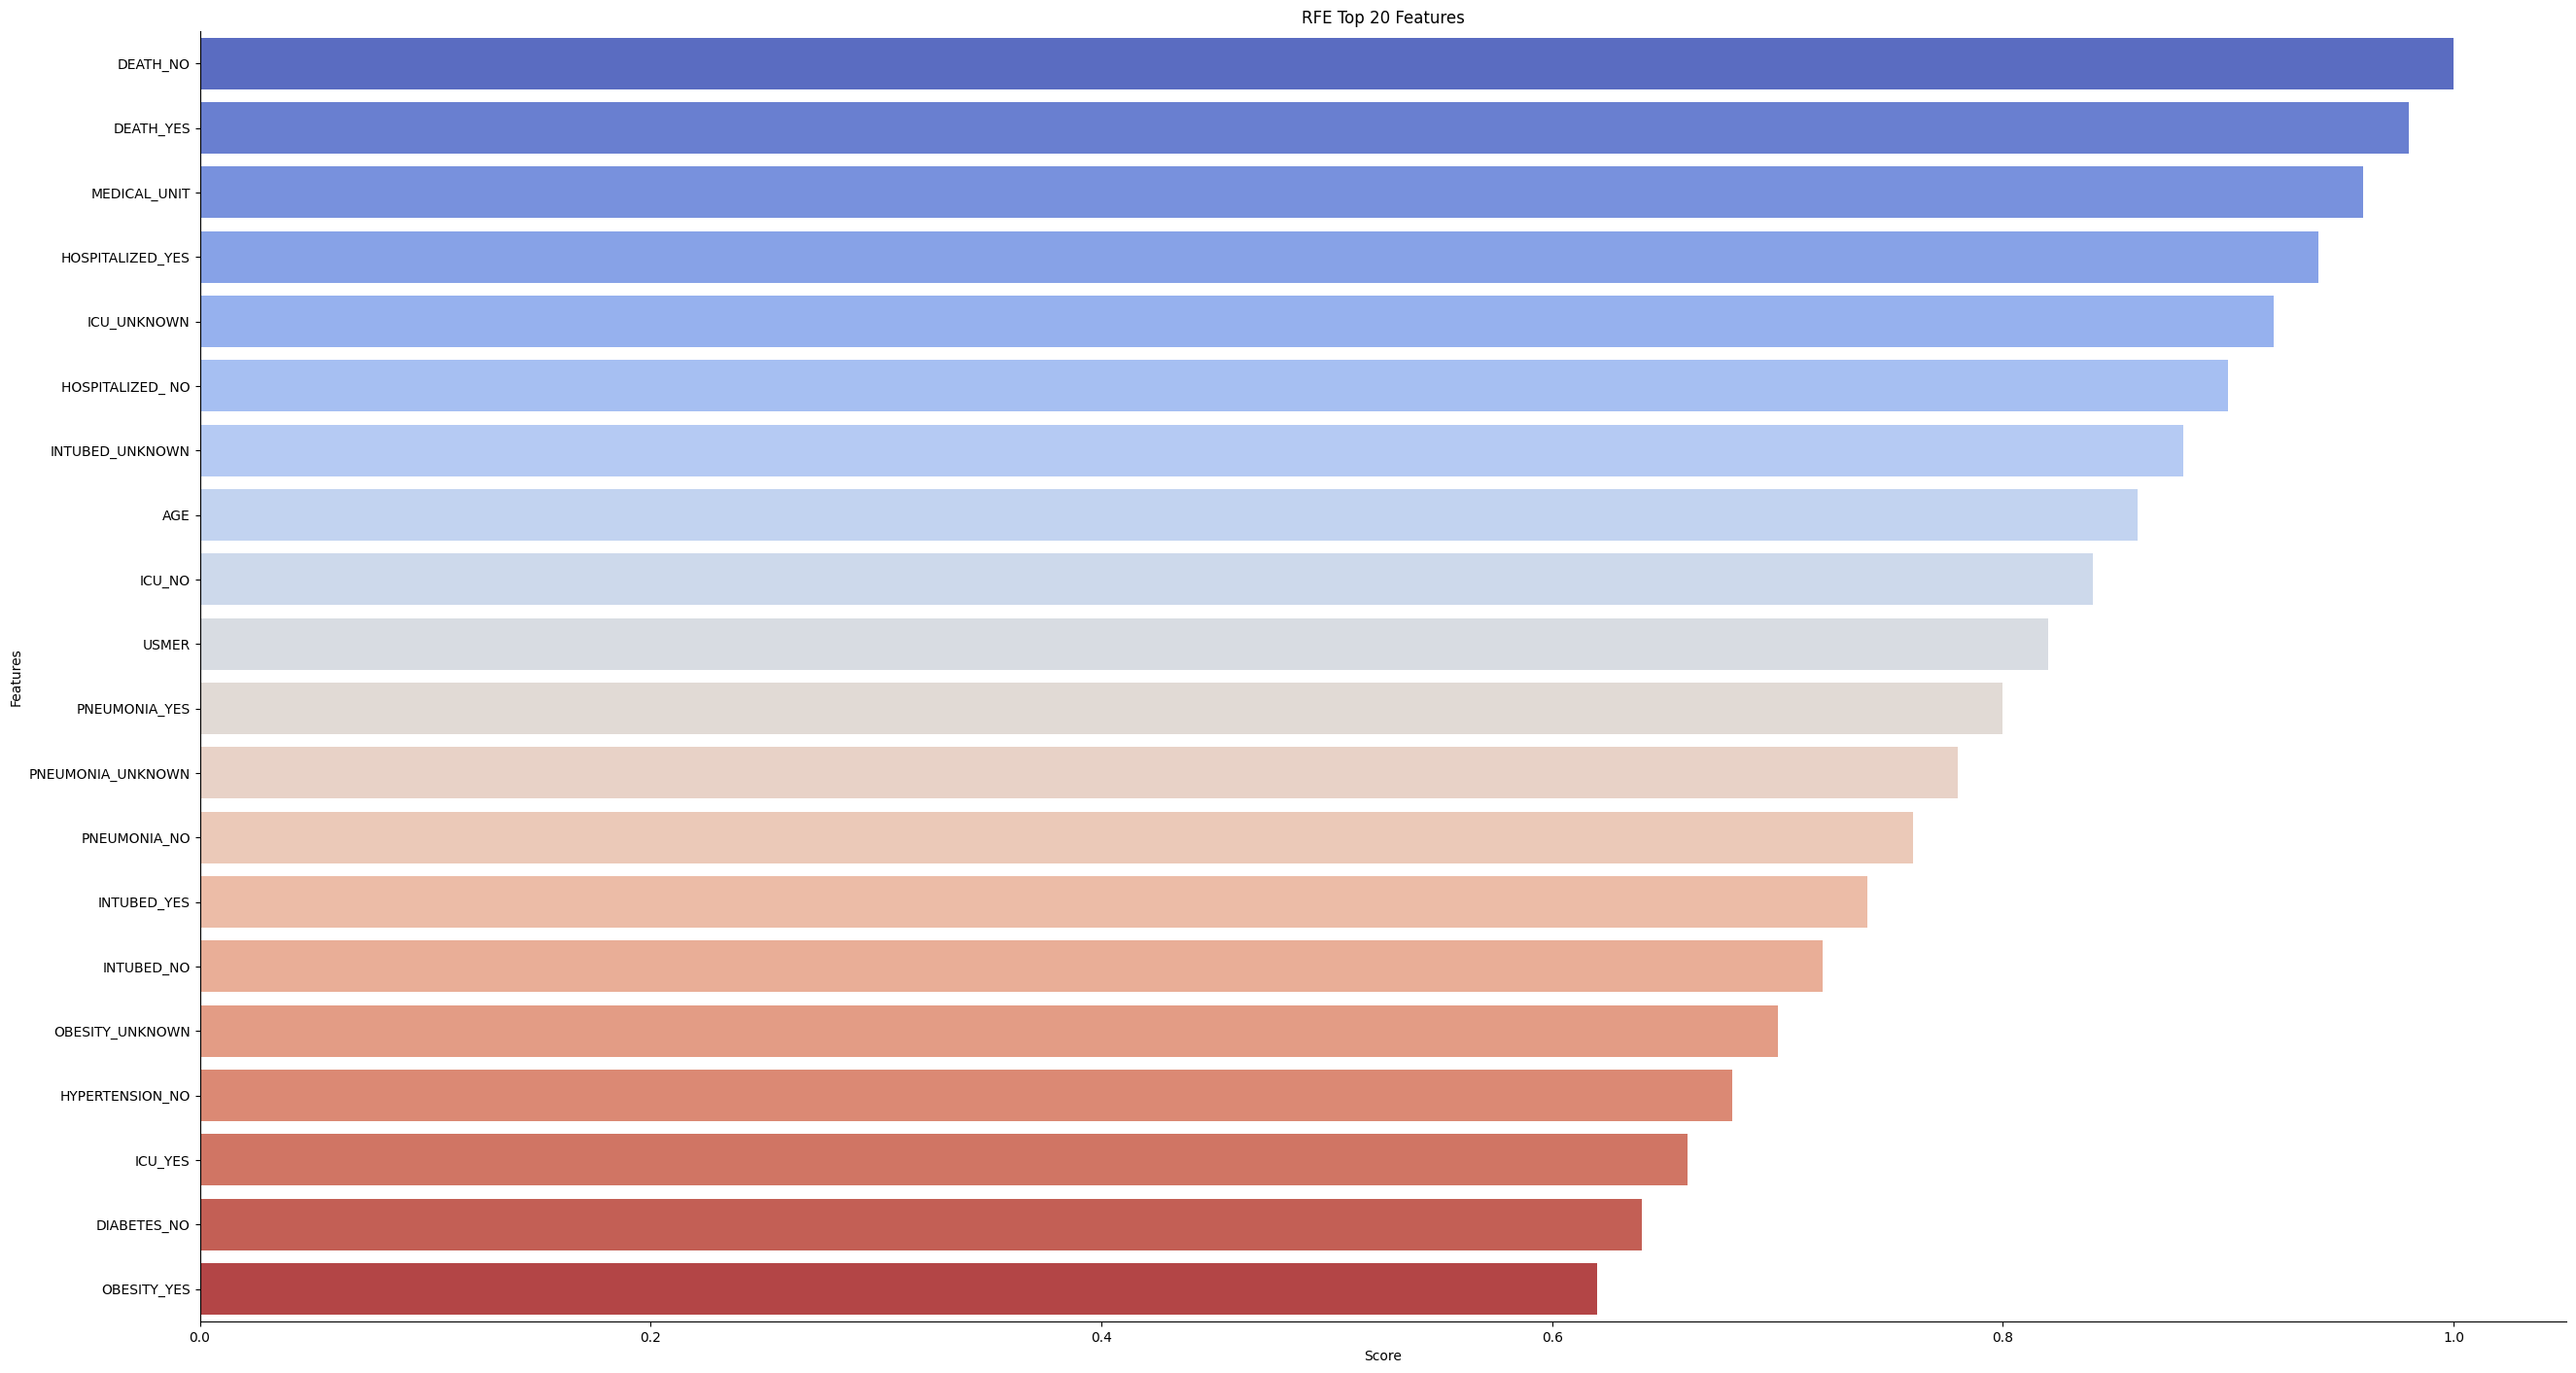

In [30]:
sns_rfe_plot = sns.catplot(x="Score", y="Features", data = rfe_score[:20], kind = "bar", 
               height=14, aspect=1.9, palette='coolwarm')
plt.title("RFE Top 20 Features")
sns_rfe_plot

### Naive Bayes (var_smoothing=1e-9)

In [74]:
rfe_top20 = pd.read_csv('RFE_Top20.csv', index_col = 0)

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X[rfe_top20['Features']], y, test_size=0.2, random_state=42)

In [86]:
nb_1 = GaussianNB(var_smoothing=1e-9)
nb_1.fit(X_train, y_train)
y_pred = nb_1.predict(X_test)
# Calculate the overall accuracy on test set 

print("Accuracy on training set: {:.3f}".format(nb_1.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(nb_1.score(X_test, y_test)))

confusion_majority = confusion_matrix(y_test, y_pred)

print('Mjority classifier Confusion Matrix\n', confusion_majority)
    
prob_NBb_1 = nb_1.predict_proba(X_test)
#prob_NBb_1 = prob_NBb_1[:, 1]

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=nb_1.predict(X_test))
print(sk_report)

Accuracy on training set: 0.599
Accuracy on test set: 0.600
Mjority classifier Confusion Matrix
 [[107829    348   3945  19302]
 [  1144      8    152    377]
 [     0      0    344     26]
 [ 49061    205   9355  17619]]
              precision    recall  f1-score   support

           0   0.682315  0.820467  0.745041    131424
           1   0.014260  0.004759  0.007136      1681
           2   0.024935  0.929730  0.048567       370
           3   0.472056  0.231099  0.310292     76240

    accuracy                       0.599862    209715
   macro avg   0.298391  0.496514  0.277759    209715
weighted avg   0.599362  0.599862  0.579848    209715



In [122]:
# save the model to disk
pickle.dump(nb_1, open('nb_1.pkl', 'wb'))

In [123]:
# load the model from disk
nb_1 = pickle.load(open('nb_1.pkl', 'rb'))

In [130]:
report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=nb_1.predict(X_test), 
    output_dict=True)
result = pd.DataFrame(report).transpose()
print(result)

              precision    recall  f1-score        support
0              0.682315  0.820467  0.745041  131424.000000
1              0.014260  0.004759  0.007136    1681.000000
2              0.024935  0.929730  0.048567     370.000000
3              0.472056  0.231099  0.310292   76240.000000
accuracy       0.599862  0.599862  0.599862       0.599862
macro avg      0.298391  0.496514  0.277759  209715.000000
weighted avg   0.599362  0.599862  0.579848  209715.000000


In [171]:
# Make predictions on the test set
y_pred = nb_1.predict(X_test)

# Calculate the accuracy, precision, recall, F1-score, and AUC-ROC
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Binarize the target labels
lb = LabelBinarizer()
y_binarized = lb.fit_transform(y_test)

# Predict the probabilities of the positive class for the test set
y_probs = nb_1.predict_proba(X_test)

# Compute the AUC score for each class
fpr, tpr, _ = roc_curve(y_binarized.ravel(), y_probs.ravel())
auc = roc_auc_score(y_binarized, y_probs)

# Print the results
print("Accuracy: {:.4f}".format(acc))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("AUC-ROC: {:.4f}".format(auc))

Accuracy: 0.5999
Precision: 0.2984
Recall: 0.4965
F1-score: 0.2778
AUC-ROC: 0.6855


AUC score:  0.6854905379839866


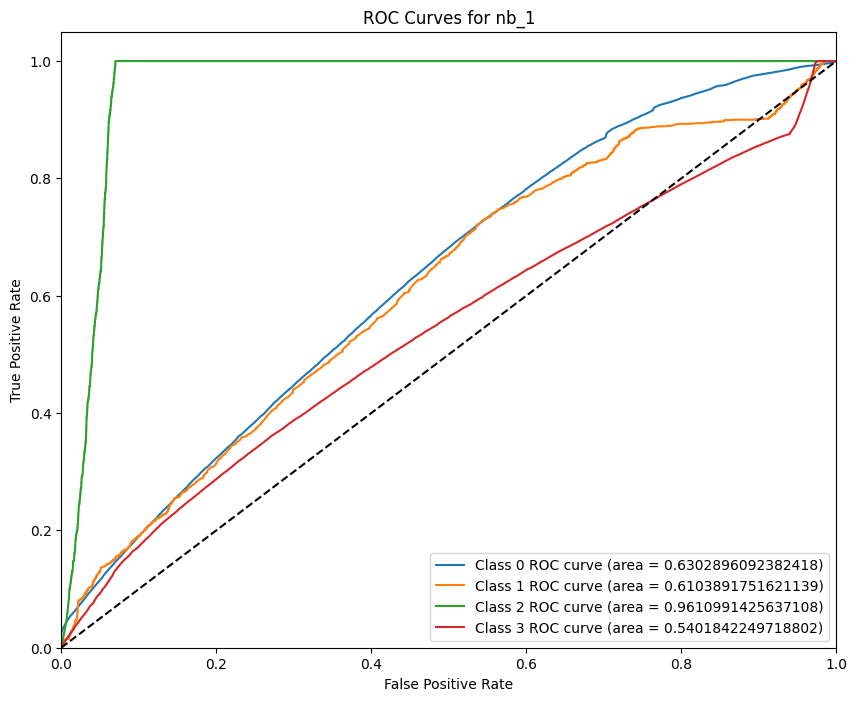

In [239]:
# Binarize the target labels
lb = LabelBinarizer()
y_binarized = lb.fit_transform(y_test)

# Predict the probabilities of the positive class for the test set
y_probs = nb_1.predict_proba(X_test)

# Compute the AUC score for each class
fpr_nb_1, tpr_nb_1, _ = roc_curve(y_binarized.ravel(), y_probs.ravel())
auc = roc_auc_score(y_binarized, y_probs)
print("AUC score: ", auc)

plt.figure(figsize=(10, 8))
for i in range(lb.classes_.shape[0]):
    y_test_binary = y_binarized[:, i]
    y_probs = nb_1.predict_proba(X_test)[:, i]
    fpr, tpr, thresholds = roc_curve(y_test_binary, y_probs)
    roc_auc = roc_auc_score(y_test_binary, y_probs)
    plt.plot(fpr, tpr, label='Class {} ROC curve (area = {})'.format(i, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for nb_1')
plt.legend(loc="lower right")
plt.show()

### Naive Bayes (var_smoothing=1e-6)

In [87]:
nb_2 = GaussianNB(var_smoothing=1e-6)
nb_2.fit(X_train, y_train)
y_pred = nb_2.predict(X_test)
# Calculate the overall accuracy on test set 

print("Accuracy on training set: {:.3f}".format(nb_2.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(nb_2.score(X_test, y_test)))

confusion_majority = confusion_matrix(y_test, y_pred)

print('Mjority classifier Confusion Matrix\n', confusion_majority)
    
prob_NBb_1 = nb_2.predict_proba(X_test)
#prob_NBb_1 = prob_NBb_1[:, 1]

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=nb_2.predict(X_test))
print(sk_report)

Accuracy on training set: 0.607
Accuracy on test set: 0.608
Mjority classifier Confusion Matrix
 [[111954    286   3905  15279]
 [  1195      8    152    326]
 [     0      0    339     31]
 [ 51727    184   9181  15148]]
              precision    recall  f1-score   support

           0   0.679019  0.851854  0.755680    131424
           1   0.016736  0.004759  0.007411      1681
           2   0.024969  0.916216  0.048613       370
           3   0.492074  0.198688  0.283077     76240

    accuracy                       0.607725    209715
   macro avg   0.303200  0.492879  0.273695    209715
weighted avg   0.604594  0.607725  0.576624    209715



In [126]:
# save the model to disk
pickle.dump(nb_2, open('nb_2.pkl', 'wb'))

In [134]:
# load the model from disk
nb_2 = pickle.load(open('nb_2.pkl', 'rb'))

In [135]:
report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=nb_2.predict(X_test), 
    output_dict=True)
result = pd.DataFrame(report).transpose()
print(result)

              precision    recall  f1-score        support
0              0.679019  0.851854  0.755680  131424.000000
1              0.016736  0.004759  0.007411    1681.000000
2              0.024969  0.916216  0.048613     370.000000
3              0.492074  0.198688  0.283077   76240.000000
accuracy       0.607725  0.607725  0.607725       0.607725
macro avg      0.303200  0.492879  0.273695  209715.000000
weighted avg   0.604594  0.607725  0.576624  209715.000000


In [172]:
# Make predictions on the test set
y_pred = nb_2.predict(X_test)

# Calculate the accuracy, precision, recall, F1-score, and AUC-ROC
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Binarize the target labels
lb = LabelBinarizer()
y_binarized = lb.fit_transform(y_test)

# Predict the probabilities of the positive class for the test set
y_probs = nb_2.predict_proba(X_test)

# Compute the AUC score for each class
fpr, tpr, _ = roc_curve(y_binarized.ravel(), y_probs.ravel())
auc = roc_auc_score(y_binarized, y_probs)

# Print the results
print("Accuracy: {:.4f}".format(acc))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("AUC-ROC: {:.4f}".format(auc))

Accuracy: 0.6077
Precision: 0.3032
Recall: 0.4929
F1-score: 0.2737
AUC-ROC: 0.6806


AUC score:  0.6805688815526013


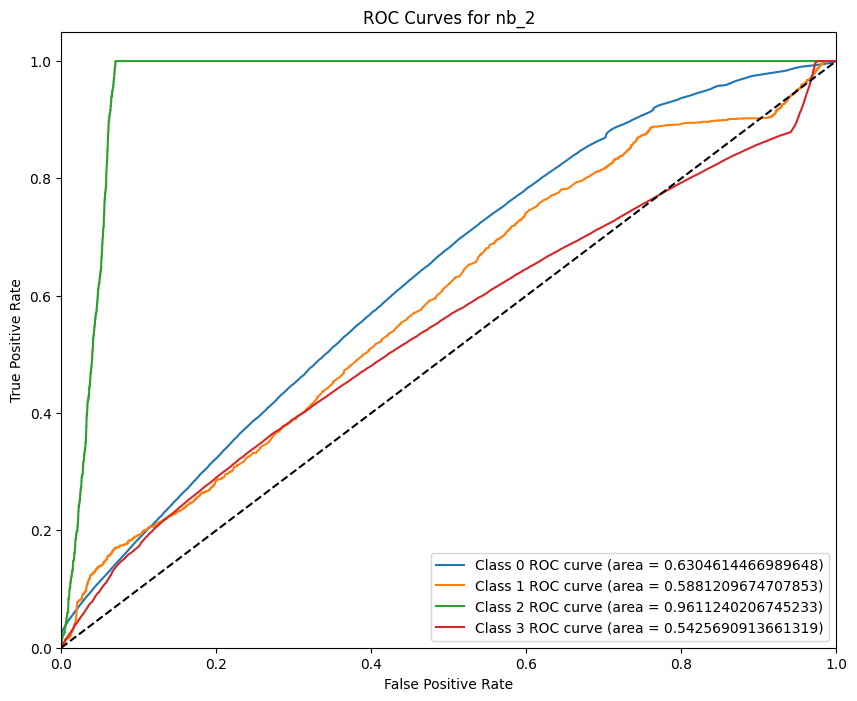

In [240]:
# Binarize the target labels
lb = LabelBinarizer()
y_binarized = lb.fit_transform(y_test)

# Predict the probabilities of the positive class for the test set
y_probs = nb_2.predict_proba(X_test)

# Compute the AUC score for each class
fpr_nb_2, tpr_nb_2, _ = roc_curve(y_binarized.ravel(), y_probs.ravel())
auc = roc_auc_score(y_binarized, y_probs)
print("AUC score: ", auc)

plt.figure(figsize=(10, 8))
for i in range(lb.classes_.shape[0]):
    y_test_binary = y_binarized[:, i]
    y_probs = nb_2.predict_proba(X_test)[:, i]
    fpr, tpr, thresholds = roc_curve(y_test_binary, y_probs)
    roc_auc = roc_auc_score(y_test_binary, y_probs)
    plt.plot(fpr, tpr, label='Class {} ROC curve (area = {})'.format(i, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for nb_2')
plt.legend(loc="lower right")
plt.show()

### Naive Bayes (var_smoothing=1e-3)

In [90]:
nb_3 = GaussianNB(var_smoothing=1e-3)
nb_3.fit(X_train, y_train)
y_pred = nb_3.predict(X_test)
# Calculate the overall accuracy on test set 

print("Accuracy on training set: {:.3f}".format(nb_3.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(nb_3.score(X_test, y_test)))

confusion_majority = confusion_matrix(y_test, y_pred)

print('Mjority classifier Confusion Matrix\n', confusion_majority)
    
prob_NBb_1 = nb_3.predict_proba(X_test)
#prob_NBb_1 = prob_NBb_1[:, 1]

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=nb_3.predict(X_test))
print(sk_report)

Accuracy on training set: 0.621
Accuracy on test set: 0.622
Mjority classifier Confusion Matrix
 [[115715      0   2881  12828]
 [  1272      0    117    292]
 [    17      0    273     80]
 [ 54525      0   7290  14425]]
              precision    recall  f1-score   support

           0   0.674609  0.880471  0.763914    131424
           1   0.000000  0.000000  0.000000      1681
           2   0.025850  0.737838  0.049950       370
           3   0.522172  0.189205  0.277764     76240

    accuracy                       0.621858    209715
   macro avg   0.305658  0.451878  0.272907    209715
weighted avg   0.612640  0.621858  0.579796    209715



In [137]:
# save the model to disk
pickle.dump(nb_3, open('nb_3.pkl', 'wb'))

In [138]:
# load the model from disk
nb_3 = pickle.load(open('nb_3.pkl', 'rb'))

In [139]:
report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=nb_3.predict(X_test), 
    output_dict=True)
result = pd.DataFrame(report).transpose()
print(result)

              precision    recall  f1-score        support
0              0.674609  0.880471  0.763914  131424.000000
1              0.000000  0.000000  0.000000    1681.000000
2              0.025850  0.737838  0.049950     370.000000
3              0.522172  0.189205  0.277764   76240.000000
accuracy       0.621858  0.621858  0.621858       0.621858
macro avg      0.305658  0.451878  0.272907  209715.000000
weighted avg   0.612640  0.621858  0.579796  209715.000000


In [173]:
# Make predictions on the test set
y_pred = nb_3.predict(X_test)

# Calculate the accuracy, precision, recall, F1-score, and AUC-ROC
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Binarize the target labels
lb = LabelBinarizer()
y_binarized = lb.fit_transform(y_test)

# Predict the probabilities of the positive class for the test set
y_probs = nb_3.predict_proba(X_test)

# Compute the AUC score for each class
fpr, tpr, _ = roc_curve(y_binarized.ravel(), y_probs.ravel())
auc = roc_auc_score(y_binarized, y_probs)

# Print the results
print("Accuracy: {:.4f}".format(acc))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("AUC-ROC: {:.4f}".format(auc))

Accuracy: 0.6219
Precision: 0.3057
Recall: 0.4519
F1-score: 0.2729
AUC-ROC: 0.6990


AUC score:  0.699017418503085


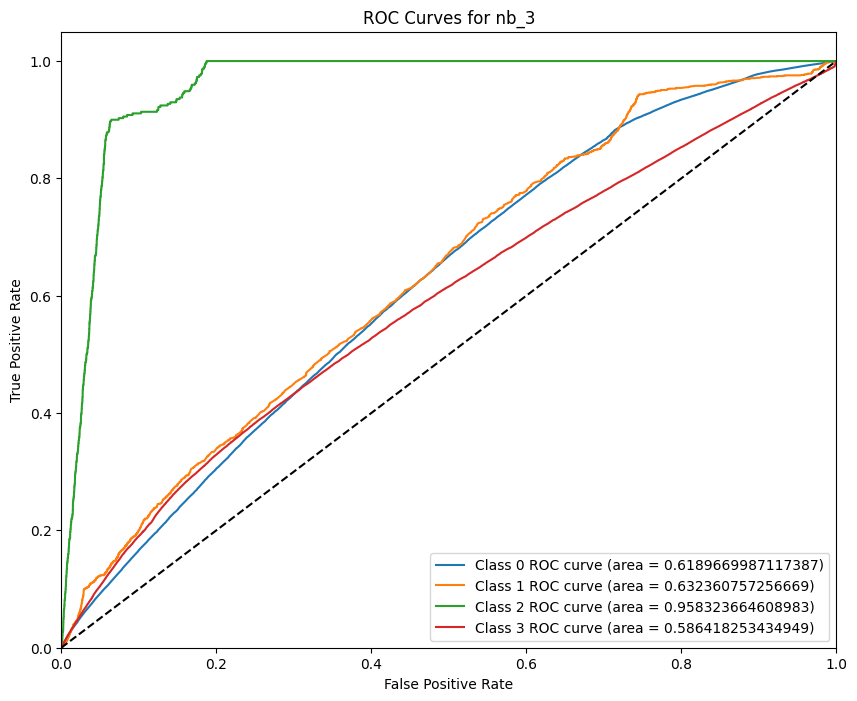

In [241]:
# Binarize the target labels
lb = LabelBinarizer()
y_binarized = lb.fit_transform(y_test)

# Predict the probabilities of the positive class for the test set
y_probs = nb_3.predict_proba(X_test)

# Compute the AUC score for each class
fpr_nb_3, tpr_nb_3, _ = roc_curve(y_binarized.ravel(), y_probs.ravel())
auc = roc_auc_score(y_binarized, y_probs)
print("AUC score: ", auc)

plt.figure(figsize=(10, 8))
for i in range(lb.classes_.shape[0]):
    y_test_binary = y_binarized[:, i]
    y_probs = nb_3.predict_proba(X_test)[:, i]
    fpr, tpr, thresholds = roc_curve(y_test_binary, y_probs)
    roc_auc = roc_auc_score(y_test_binary, y_probs)
    plt.plot(fpr, tpr, label='Class {} ROC curve (area = {})'.format(i, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for nb_3')
plt.legend(loc="lower right")
plt.show()

### Overall ROC Curve for Naive Bayes

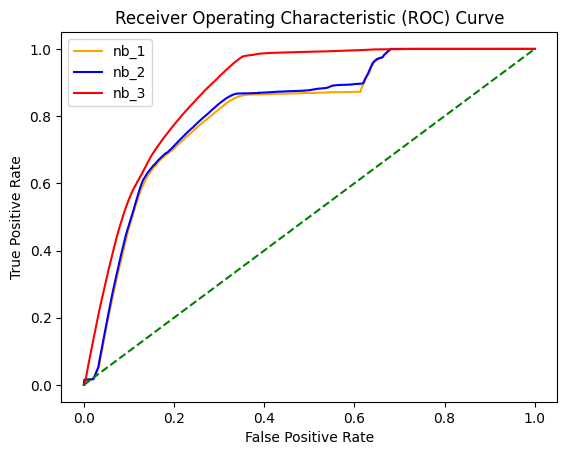

In [242]:
plt.plot(fpr_nb_1, tpr_nb_1, color='orange', label='nb_1')
plt.plot(fpr_nb_2, tpr_nb_2, color='blue', label='nb_2')
plt.plot(fpr_nb_3, tpr_nb_3, color='red', label='nb_3')
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

### Random Forest Classifier (depth = 3, trees = 300)

In [93]:
rf_1 = RandomForestClassifier(random_state=42, n_estimators=300, max_depth=3)
rf_1.fit(X_train, y_train)
y_pred = rf_1.predict(X_test)

# Calculate the overall accuracy on test set 

print("Accuracy on training set: {:.3f}".format(rf_1.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf_1.score(X_test, y_test)))

confusion_majority = confusion_matrix(y_test, y_pred)

print('Mjority classifier Confusion Matrix\n', confusion_majority)
    
prob_RF_1 = rf_1.predict_proba(X_test)
#prob_RF_1 = prob_RF_1[:, 1]

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=rf_1.predict(X_test))
print(sk_report)

Accuracy on training set: 0.662
Accuracy on test set: 0.663
Mjority classifier Confusion Matrix
 [[121939      0      0   9485]
 [  1388      0      0    293]
 [     0      0      0    370]
 [ 59186      0      0  17054]]
              precision    recall  f1-score   support

           0   0.668111  0.927829  0.776837    131424
           1   0.000000  0.000000  0.000000      1681
           2   0.000000  0.000000  0.000000       370
           3   0.626939  0.223688  0.329731     76240

    accuracy                       0.662771    209715
   macro avg   0.323763  0.287879  0.276642    209715
weighted avg   0.646609  0.662771  0.606698    209715



In [141]:
# save the model to disk
pickle.dump(rf_1, open('rf_1.pkl', 'wb'))

In [ ]:
# load the model from disk
rf_1 = pickle.load(open('rf_1.pkl', 'rb'))

In [94]:
report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=rf_1.predict(X_test), 
    output_dict=True)
result = pd.DataFrame(report).transpose()
print(result)

              precision    recall  f1-score        support
0              0.668111  0.927829  0.776837  131424.000000
1              0.000000  0.000000  0.000000    1681.000000
2              0.000000  0.000000  0.000000     370.000000
3              0.626939  0.223688  0.329731   76240.000000
accuracy       0.662771  0.662771  0.662771       0.662771
macro avg      0.323763  0.287879  0.276642  209715.000000
weighted avg   0.646609  0.662771  0.606698  209715.000000


In [174]:
# Make predictions on the test set
y_pred = rf_1.predict(X_test)

# Calculate the accuracy, precision, recall, F1-score, and AUC-ROC
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Binarize the target labels
lb = LabelBinarizer()
y_binarized = lb.fit_transform(y_test)

# Predict the probabilities of the positive class for the test set
y_probs = rf_1.predict_proba(X_test)

# Compute the AUC score for each class
fpr, tpr, _ = roc_curve(y_binarized.ravel(), y_probs.ravel())
auc = roc_auc_score(y_binarized, y_probs)

# Print the results
print("Accuracy: {:.4f}".format(acc))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("AUC-ROC: {:.4f}".format(auc))

Accuracy: 0.6628
Precision: 0.3238
Recall: 0.2879
F1-score: 0.2766
AUC-ROC: 0.7017


AUC score:  0.7017295859722722


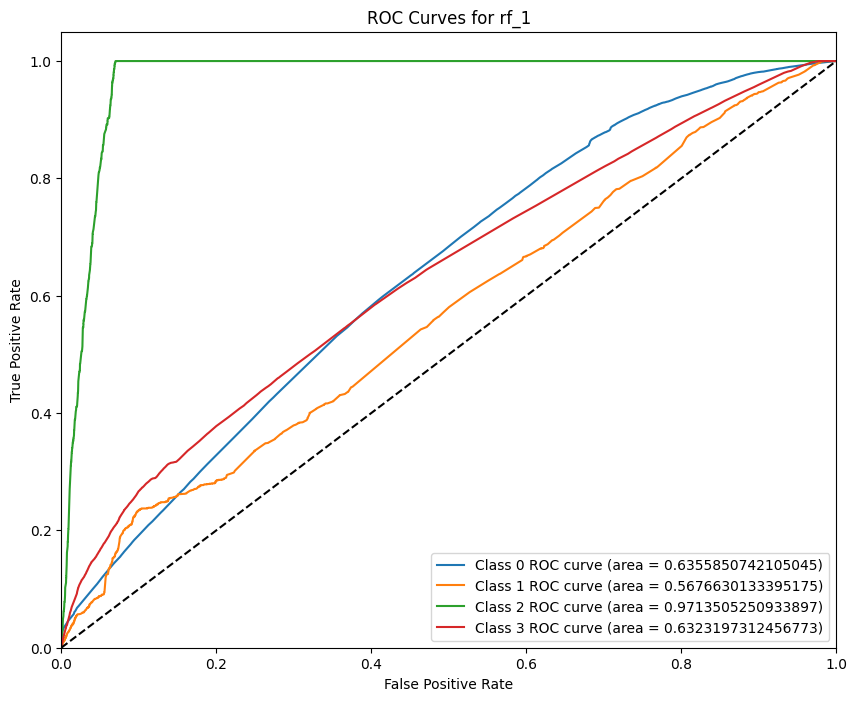

In [243]:
# Binarize the target labels
lb = LabelBinarizer()
y_binarized = lb.fit_transform(y_test)

# Predict the probabilities of the positive class for the test set
y_probs = rf_1.predict_proba(X_test)

# Compute the AUC score for each class
fpr_rf_1, tpr_rf_1, _ = roc_curve(y_binarized.ravel(), y_probs.ravel())
auc = roc_auc_score(y_binarized, y_probs)
print("AUC score: ", auc)

plt.figure(figsize=(10, 8))
for i in range(lb.classes_.shape[0]):
    y_test_binary = y_binarized[:, i]
    y_probs = rf_1.predict_proba(X_test)[:, i]
    fpr, tpr, thresholds = roc_curve(y_test_binary, y_probs)
    roc_auc = roc_auc_score(y_test_binary, y_probs)
    plt.plot(fpr, tpr, label='Class {} ROC curve (area = {})'.format(i, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for rf_1')
plt.legend(loc="lower right")
plt.show()

### Random Forest Classifier (depth = 5, trees = 300)

In [96]:
rf_2 = RandomForestClassifier(random_state=42, n_estimators=300, max_depth=5)
rf_2.fit(X_train, y_train)
y_pred = rf_2.predict(X_test)

# Calculate the overall accuracy on test set 

print("Accuracy on training set: {:.3f}".format(rf_2.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf_2.score(X_test, y_test)))

confusion_majority = confusion_matrix(y_test, y_pred)

print('Mjority classifier Confusion Matrix\n', confusion_majority)
    
prob_RF_2 = rf_2.predict_proba(X_test)
#prob_RF_2 = prob_rf_2[:, 1]

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=rf_2.predict(X_test))
print(sk_report)

Accuracy on training set: 0.663
Accuracy on test set: 0.664
Mjority classifier Confusion Matrix
 [[121426      0      0   9998]
 [  1384      0      0    297]
 [     1      0      0    369]
 [ 58457      0      0  17783]]
              precision    recall  f1-score   support

           0   0.669870  0.923926  0.776649    131424
           1   0.000000  0.000000  0.000000      1681
           2   0.000000  0.000000  0.000000       370
           3   0.625127  0.233250  0.339737     76240

    accuracy                       0.663801    209715
   macro avg   0.323749  0.289294  0.279096    209715
weighted avg   0.647053  0.663801  0.610218    209715



In [142]:
# save the model to disk
pickle.dump(rf_2, open('rf_2.pkl', 'wb'))

In [ ]:
# load the model from disk
rf_2 = pickle.load(open('rf_2.pkl', 'rb'))

In [97]:
report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=rf_2.predict(X_test), 
    output_dict=True)
result = pd.DataFrame(report).transpose()
print(result)

              precision    recall  f1-score        support
0              0.669870  0.923926  0.776649  131424.000000
1              0.000000  0.000000  0.000000    1681.000000
2              0.000000  0.000000  0.000000     370.000000
3              0.625127  0.233250  0.339737   76240.000000
accuracy       0.663801  0.663801  0.663801       0.663801
macro avg      0.323749  0.289294  0.279096  209715.000000
weighted avg   0.647053  0.663801  0.610218  209715.000000


In [175]:
# Make predictions on the test set
y_pred = rf_2.predict(X_test)

# Calculate the accuracy, precision, recall, F1-score, and AUC-ROC
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Binarize the target labels
lb = LabelBinarizer()
y_binarized = lb.fit_transform(y_test)

# Predict the probabilities of the positive class for the test set
y_probs = rf_2.predict_proba(X_test)

# Compute the AUC score for each class
fpr, tpr, _ = roc_curve(y_binarized.ravel(), y_probs.ravel())
auc = roc_auc_score(y_binarized, y_probs)

# Print the results
print("Accuracy: {:.4f}".format(acc))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("AUC-ROC: {:.4f}".format(auc))

Accuracy: 0.6638
Precision: 0.3237
Recall: 0.2893
F1-score: 0.2791
AUC-ROC: 0.7111


AUC score:  0.7111475707074615


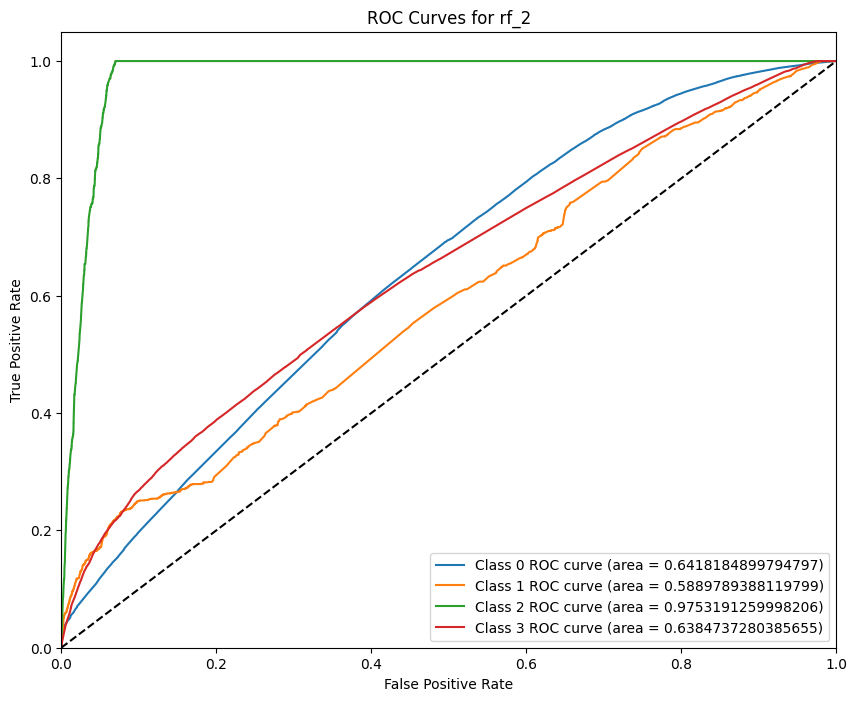

In [244]:
# Binarize the target labels
lb = LabelBinarizer()
y_binarized = lb.fit_transform(y_test)

# Predict the probabilities of the positive class for the test set
y_probs = rf_2.predict_proba(X_test)

# Compute the AUC score for each class
fpr_rf_2, tpr_rf_2, _ = roc_curve(y_binarized.ravel(), y_probs.ravel())
auc = roc_auc_score(y_binarized, y_probs)
print("AUC score: ", auc)

plt.figure(figsize=(10, 8))
for i in range(lb.classes_.shape[0]):
    y_test_binary = y_binarized[:, i]
    y_probs = rf_2.predict_proba(X_test)[:, i]
    fpr, tpr, thresholds = roc_curve(y_test_binary, y_probs)
    roc_auc = roc_auc_score(y_test_binary, y_probs)
    plt.plot(fpr, tpr, label='Class {} ROC curve (area = {})'.format(i, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for rf_2')
plt.legend(loc="lower right")
plt.show()

### Random Forest Classifier (depth = 5, trees = 500)

In [99]:
rf_3 = RandomForestClassifier(random_state=42, n_estimators=500, max_depth=5)
rf_3.fit(X_train, y_train)
y_pred = rf_3.predict(X_test)

# Calculate the overall accuracy on test set 

print("Accuracy on training set: {:.3f}".format(rf_3.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf_3.score(X_test, y_test)))

confusion_majority = confusion_matrix(y_test, y_pred)

print('Mjority classifier Confusion Matrix\n', confusion_majority)
    
prob_RF_3 = rf_3.predict_proba(X_test)
#prob_RF_3 = prob_RF_3[:, 1]

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=rf_3.predict(X_test))
print(sk_report)

Accuracy on training set: 0.663
Accuracy on test set: 0.664
Mjority classifier Confusion Matrix
 [[121436      0      0   9988]
 [  1384      0      0    297]
 [     1      0      0    369]
 [ 58474      0      0  17766]]
              precision    recall  f1-score   support

           0   0.669825  0.924002  0.776646    131424
           1   0.000000  0.000000  0.000000      1681
           2   0.000000  0.000000  0.000000       370
           3   0.625123  0.233027  0.339499     76240

    accuracy                       0.663767    209715
   macro avg   0.323737  0.289257  0.279036    209715
weighted avg   0.647023  0.663767  0.610130    209715



In [143]:
# save the model to disk
pickle.dump(rf_3, open('rf_3.pkl', 'wb'))

In [ ]:
# load the model from disk
rf_3 = pickle.load(open('rf_3.pkl', 'rb'))

In [100]:
report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=rf_3.predict(X_test), 
    output_dict=True)
result = pd.DataFrame(report).transpose()
print(result)

              precision    recall  f1-score        support
0              0.669825  0.924002  0.776646  131424.000000
1              0.000000  0.000000  0.000000    1681.000000
2              0.000000  0.000000  0.000000     370.000000
3              0.625123  0.233027  0.339499   76240.000000
accuracy       0.663767  0.663767  0.663767       0.663767
macro avg      0.323737  0.289257  0.279036  209715.000000
weighted avg   0.647023  0.663767  0.610130  209715.000000


In [176]:
# Make predictions on the test set
y_pred = rf_3.predict(X_test)

# Calculate the accuracy, precision, recall, F1-score, and AUC-ROC
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Binarize the target labels
lb = LabelBinarizer()
y_binarized = lb.fit_transform(y_test)

# Predict the probabilities of the positive class for the test set
y_probs = rf_3.predict_proba(X_test)

# Compute the AUC score for each class
fpr, tpr, _ = roc_curve(y_binarized.ravel(), y_probs.ravel())
auc = roc_auc_score(y_binarized, y_probs)

# Print the results
print("Accuracy: {:.4f}".format(acc))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("AUC-ROC: {:.4f}".format(auc))

Accuracy: 0.6638
Precision: 0.3237
Recall: 0.2893
F1-score: 0.2790
AUC-ROC: 0.7114


AUC score:  0.7113938728871162


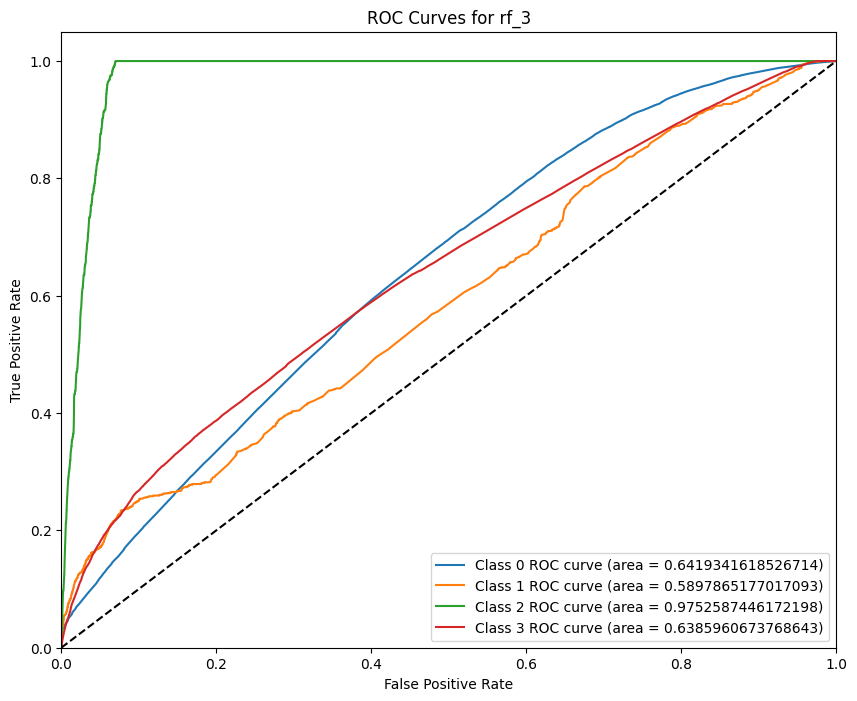

In [245]:
# Binarize the target labels
lb = LabelBinarizer()
y_binarized = lb.fit_transform(y_test)

# Predict the probabilities of the positive class for the test set
y_probs = rf_3.predict_proba(X_test)

# Compute the AUC score for each class
fpr_rf_3, tpr_rf_3, _ = roc_curve(y_binarized.ravel(), y_probs.ravel())
auc = roc_auc_score(y_binarized, y_probs)
print("AUC score: ", auc)

plt.figure(figsize=(10, 8))
for i in range(lb.classes_.shape[0]):
    y_test_binary = y_binarized[:, i]
    y_probs = rf_3.predict_proba(X_test)[:, i]
    fpr, tpr, thresholds = roc_curve(y_test_binary, y_probs)
    roc_auc = roc_auc_score(y_test_binary, y_probs)
    plt.plot(fpr, tpr, label='Class {} ROC curve (area = {})'.format(i, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for rf_3')
plt.legend(loc="lower right")
plt.show()

### Overall ROC Curve for Random Forest

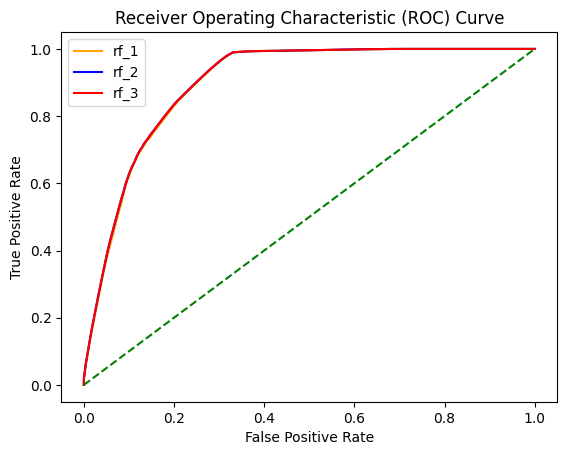

In [252]:
plt.plot(fpr_rf_1, tpr_rf_1, color='orange', label='rf_1')
plt.plot(fpr_rf_2, tpr_rf_2, color='blue', label='rf_2')
plt.plot(fpr_rf_3, tpr_rf_3, color='red', label='rf_3')
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

### Feedforward Neural Network (128)

In [185]:
sc = StandardScaler()
X_ss = sc.fit_transform(X[rfe_top20['Features']])
print(X_ss)

[[-3.55360697  3.55360697 -2.14342559 ... -0.12782704  0.37342774
  -0.42405103]
 [-3.55360697  3.55360697 -2.14342559 ... -0.12782704  0.37342774
   2.35820675]
 [-3.55360697  3.55360697 -2.14342559 ... -0.12782704 -2.67789424
  -0.42405103]
 ...
 [ 0.28140422 -0.28140422  1.07954257 ... -0.12782704  0.37342774
  -0.42405103]
 [ 0.28140422 -0.28140422  1.07954257 ... -0.12782704  0.37342774
  -0.42405103]
 [ 0.28140422 -0.28140422  1.07954257 ... -0.12782704  0.37342774
  -0.42405103]]


In [145]:
y_one_hot = to_categorical(y)

# Show the category label after one-hot encoding
print('Original label 0 : ', y[0])
print('After conversion to categorical ( one-hot ) : ', y_one_hot[0])

Original label 0 :  3
After conversion to categorical ( one-hot ) :  [0. 0. 0. 1.]


In [106]:
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{0: 656596, 1: 8601, 2: 1851, 3: 381527}

In [248]:
X_train,X_test,y_train,y_test = train_test_split(X_ss, y_one_hot, test_size = 0.1, shuffle= True)

In [212]:
model_1 = Sequential()
model_1.add(Dense(128, input_dim=20, activation='sigmoid'))
model_1.add(Dropout(0.5))
model_1.add(Dense(128, activation = "sigmoid"))
model_1.add(Dropout(0.5))
model_1.add(Dense(4, activation='softmax'))

In [213]:
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [214]:
model_1.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_47 (Dense)            (None, 128)               2688      
                                                                 
 dropout_30 (Dropout)        (None, 128)               0         
                                                                 
 dense_48 (Dense)            (None, 128)               16512     
                                                                 
 dropout_31 (Dropout)        (None, 128)               0         
                                                                 
 dense_49 (Dense)            (None, 4)                 516       
                                                                 
Total params: 19,716
Trainable params: 19,716
Non-trainable params: 0
_________________________________________________________________


In [215]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history_1 = model_1.fit(X_train, y_train,validation_data = (X_test,y_test), epochs=200, batch_size=64, callbacks=[early_stopping])

Epoch 1/200
14746/14746 [==============================] - 39s 3ms/step - loss: 0.6767 - accuracy: 0.6601 - val_loss: 0.6661 - val_accuracy: 0.6636
Epoch 2/200
14746/14746 [==============================] - 39s 3ms/step - loss: 0.6700 - accuracy: 0.6628 - val_loss: 0.6661 - val_accuracy: 0.6637
Epoch 3/200
14746/14746 [==============================] - 38s 3ms/step - loss: 0.6681 - accuracy: 0.6630 - val_loss: 0.6650 - val_accuracy: 0.6628
Epoch 4/200
14746/14746 [==============================] - 42s 3ms/step - loss: 0.6670 - accuracy: 0.6635 - val_loss: 0.6645 - val_accuracy: 0.6618
Epoch 5/200
14746/14746 [==============================] - 38s 3ms/step - loss: 0.6666 - accuracy: 0.6638 - val_loss: 0.6638 - val_accuracy: 0.6649
Epoch 6/200
14746/14746 [==============================] - 39s 3ms/step - loss: 0.6661 - accuracy: 0.6639 - val_loss: 0.6630 - val_accuracy: 0.6659
Epoch 7/200
14746/14746 [==============================] - 43s 3ms/step - loss: 0.6658 - accuracy: 0.6642 - val_

In [216]:
model_1.save('model_1.h5')

In [118]:
# load model
model_1=load_model('model_1.h5')

In [119]:
model_1.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 128)               2688      
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_42 (Dense)            (None, 128)               16512     
                                                                 
 dropout_27 (Dropout)        (None, 128)               0         
                                                                 
 dense_43 (Dense)            (None, 4)                 516       
                                                                 
Total params: 19,716
Trainable params: 19,716
Non-trainable params: 0
_________________________________________________________________


In [217]:
y_pred = model_1.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_binary = np.argmax(y_test, axis=1)

confusion_majority = confusion_matrix(y_test_binary, y_pred)

print('Mjority classifier Confusion Matrix\n', confusion_majority)

sk_report = classification_report(
    digits=6,
    y_true=y_test_binary, 
    y_pred=np.argmax(model_1.predict(X_test), axis=1))
print(sk_report)

3277/3277 [==============================] - 3s 861us/step
Mjority classifier Confusion Matrix
 [[61304     0     0  4318]
 [  721     0     0   119]
 [   18     0     0   166]
 [29751     0     0  8461]]
3277/3277 [==============================] - 3s 833us/step
              precision    recall  f1-score   support

           0   0.667843  0.934199  0.778879     65622
           1   0.000000  0.000000  0.000000       840
           2   0.000000  0.000000  0.000000       184
           3   0.647658  0.221423  0.330018     38212

    accuracy                       0.665328    104858
   macro avg   0.328875  0.288905  0.277224    104858
weighted avg   0.653965  0.665328  0.607700    104858



In [218]:
# Define the model predictions for each class
y_pred = model_1.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_binary = np.argmax(y_test, axis=1)

# Calculate the accuracy score
acc = accuracy_score(y_test_binary, y_pred)

# Calculate the precision score
prec = precision_score(y_test_binary, y_pred, average='weighted')

# Calculate the recall score
rec = recall_score(y_test_binary, y_pred, average='weighted')

# Calculate the F1-score
f1 = f1_score(y_test_binary, y_pred, average='weighted')

# Binarize the target labels
lb = LabelBinarizer()
y_binarized = lb.fit_transform(y_test_binary)

# Predict the probabilities of the positive class for the test set
y_probs = model_1.predict(X_test)

# Compute the AUC score for each class
fpr, tpr, _ = roc_curve(y_binarized.ravel(), y_probs.ravel())
auc = roc_auc_score(y_binarized, y_probs)

# Print the results
print("Accuracy: {:.4f}".format(acc))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("AUC-ROC: {:.4f}".format(auc))

3277/3277 [==============================] - 3s 864us/step
Accuracy: 0.6653
Precision: 0.3237
Recall: 0.2893
F1-score: 0.6077
AUC-ROC: 0.7530


3277/3277 [==============================] - 14s 4ms/step
AUC score:  0.7577096246748543
3277/3277 [==============================] - 7s 2ms/step


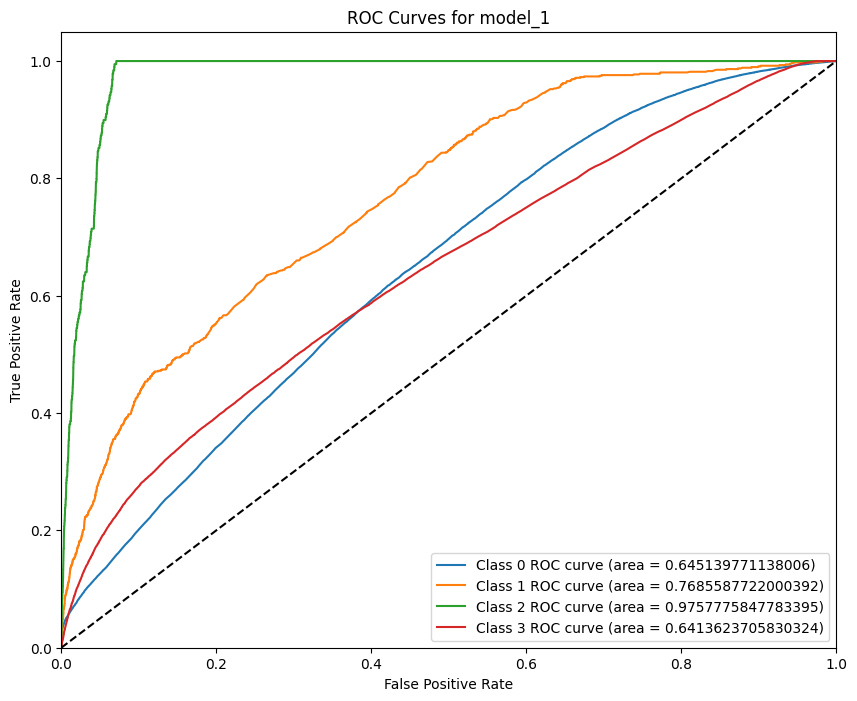

In [249]:
y_test_binary = np.argmax(y_test, axis=1)

# Binarize the target labels
lb = LabelBinarizer()
y_binarized = lb.fit_transform(y_test_binary)

# Predict the probabilities of the positive class for the test set
y_probs = model_1.predict(X_test)

# Compute the AUC score for each class
fpr_model_1, tpr_model_1, _ = roc_curve(y_binarized.ravel(), y_probs.ravel())
auc = roc_auc_score(y_binarized, y_probs)
print("AUC score: ", auc)

plt.figure(figsize=(10, 8))
for i in range(lb.classes_.shape[0]):
    y_test_binary = y_binarized[:, i]
    y_probs = model_1.predict(X_test)[:, i]
    fpr, tpr, thresholds = roc_curve(y_test_binary, y_probs)
    roc_auc = roc_auc_score(y_test_binary, y_probs)
    plt.plot(fpr, tpr, label='Class {} ROC curve (area = {})'.format(i, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for model_1')
plt.legend(loc="lower right")
plt.show()

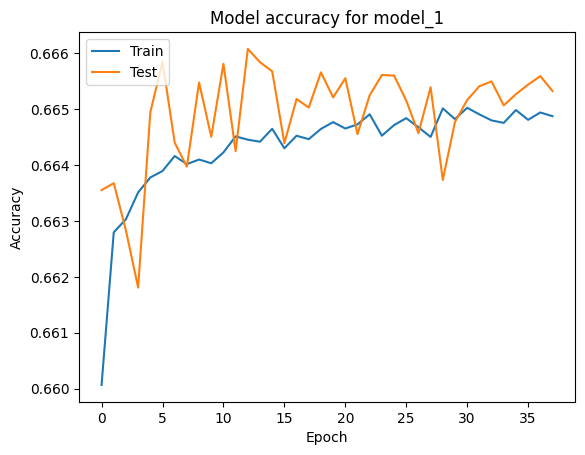

In [225]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model accuracy for model_1')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

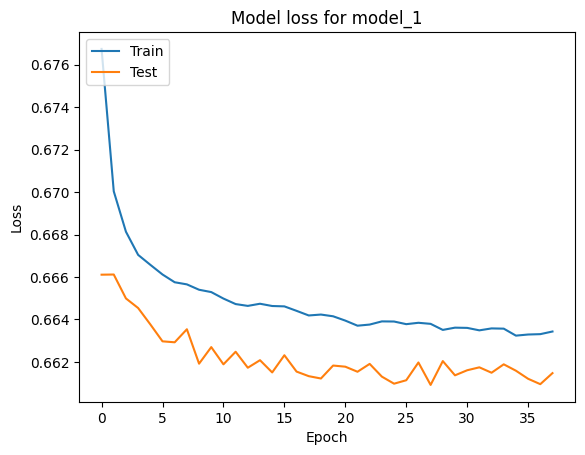

In [226]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss for model_1')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Feedforward Neural Network (64)

In [147]:
model_2 = Sequential()
model_2.add(Dense(64, input_dim=20, activation='sigmoid'))
model_2.add(Dropout(0.5))
model_2.add(Dense(64, activation = "sigmoid"))
model_2.add(Dropout(0.5))
model_2.add(Dense(4, activation='softmax'))

In [148]:
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [149]:
model_2.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 64)                1344      
                                                                 
 dropout_28 (Dropout)        (None, 64)                0         
                                                                 
 dense_45 (Dense)            (None, 64)                4160      
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                                 
 dense_46 (Dense)            (None, 4)                 260       
                                                                 
Total params: 5,764
Trainable params: 5,764
Non-trainable params: 0
_________________________________________________________________


In [150]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history_2 = model_2.fit(X_train, y_train,validation_data = (X_test,y_test), epochs=200, batch_size=64, callbacks=[early_stopping])

Epoch 1/200
14746/14746 [==============================] - 120s 8ms/step - loss: 0.6826 - accuracy: 0.6583 - val_loss: 0.6689 - val_accuracy: 0.6613
Epoch 2/200
14746/14746 [==============================] - 36s 2ms/step - loss: 0.6715 - accuracy: 0.6621 - val_loss: 0.6674 - val_accuracy: 0.6629
Epoch 3/200
14746/14746 [==============================] - 33s 2ms/step - loss: 0.6696 - accuracy: 0.6625 - val_loss: 0.6667 - val_accuracy: 0.6634
Epoch 4/200
14746/14746 [==============================] - 34s 2ms/step - loss: 0.6686 - accuracy: 0.6630 - val_loss: 0.6657 - val_accuracy: 0.6629
Epoch 5/200
14746/14746 [==============================] - 33s 2ms/step - loss: 0.6680 - accuracy: 0.6633 - val_loss: 0.6648 - val_accuracy: 0.6634
Epoch 6/200
14746/14746 [==============================] - 33s 2ms/step - loss: 0.6676 - accuracy: 0.6635 - val_loss: 0.6655 - val_accuracy: 0.6622
Epoch 7/200
14746/14746 [==============================] - 33s 2ms/step - loss: 0.6674 - accuracy: 0.6636 - val

In [151]:
model_2.save('model_2.h5')

In [ ]:
# load model
model_2=load_model('model_2.h5')

In [204]:
y_pred = model_2.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_binary = np.argmax(y_test, axis=1)

confusion_majority = confusion_matrix(y_test_binary, y_pred)

print('Mjority classifier Confusion Matrix\n', confusion_majority)

sk_report = classification_report(
    digits=6,
    y_true=y_test_binary, 
    y_pred=np.argmax(model_2.predict(X_test), axis=1))
print(sk_report)

3277/3277 [==============================] - 3s 889us/step
Mjority classifier Confusion Matrix
 [[60586     0     0  5036]
 [  701     0     0   139]
 [   11     0     0   173]
 [28978     0     0  9234]]
3277/3277 [==============================] - 3s 989us/step
              precision    recall  f1-score   support

           0   0.671120  0.923257  0.777252     65622
           1   0.000000  0.000000  0.000000       840
           2   0.000000  0.000000  0.000000       184
           3   0.633246  0.241652  0.349812     38212

    accuracy                       0.665853    104858
   macro avg   0.326092  0.291227  0.281766    104858
weighted avg   0.650764  0.665853  0.613895    104858



In [205]:
# Define the model predictions for each class
y_pred = model_2.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_binary = np.argmax(y_test, axis=1)

# Calculate the accuracy score
acc = accuracy_score(y_test_binary, y_pred)

# Calculate the precision score
prec = precision_score(y_test_binary, y_pred, average='weighted')

# Calculate the recall score
rec = recall_score(y_test_binary, y_pred, average='weighted')

# Calculate the F1-score
f1 = f1_score(y_test_binary, y_pred, average='weighted')

# Binarize the target labels
lb = LabelBinarizer()
y_binarized = lb.fit_transform(y_test_binary)

# Predict the probabilities of the positive class for the test set
y_probs = model_2.predict(X_test)

# Compute the AUC score for each class
fpr, tpr, _ = roc_curve(y_binarized.ravel(), y_probs.ravel())
auc = roc_auc_score(y_binarized, y_probs)

# Print the results
print("Accuracy: {:.4f}".format(acc))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("AUC-ROC: {:.4f}".format(auc))

3277/3277 [==============================] - 3s 894us/step
Accuracy: 0.6659
Precision: 0.3237
Recall: 0.2893
F1-score: 0.6139
AUC-ROC: 0.7486


3277/3277 [==============================] - 9s 3ms/step
AUC score:  0.7543434591014497
3277/3277 [==============================] - 10s 3ms/step


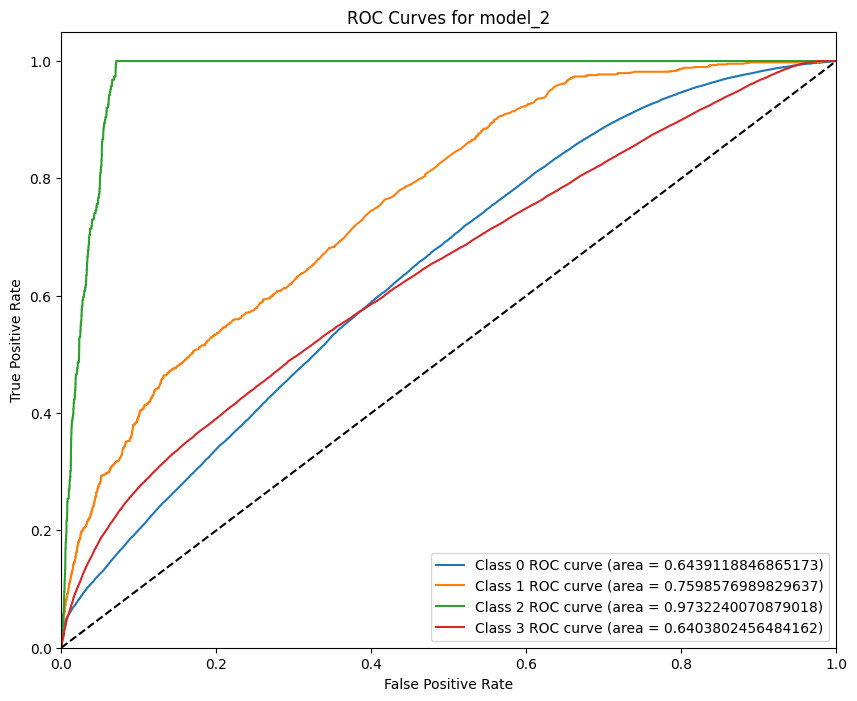

In [250]:
y_test_binary = np.argmax(y_test, axis=1)

# Binarize the target labels
lb = LabelBinarizer()
y_binarized = lb.fit_transform(y_test_binary)

# Predict the probabilities of the positive class for the test set
y_probs = model_2.predict(X_test)

# Compute the AUC score for each class
fpr_model_2, tpr_model_2, _ = roc_curve(y_binarized.ravel(), y_probs.ravel())
auc = roc_auc_score(y_binarized, y_probs)
print("AUC score: ", auc)

plt.figure(figsize=(10, 8))
for i in range(lb.classes_.shape[0]):
    y_test_binary = y_binarized[:, i]
    y_probs = model_2.predict(X_test)[:, i]
    fpr, tpr, thresholds = roc_curve(y_test_binary, y_probs)
    roc_auc = roc_auc_score(y_test_binary, y_probs)
    plt.plot(fpr, tpr, label='Class {} ROC curve (area = {})'.format(i, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for model_2')
plt.legend(loc="lower right")
plt.show()

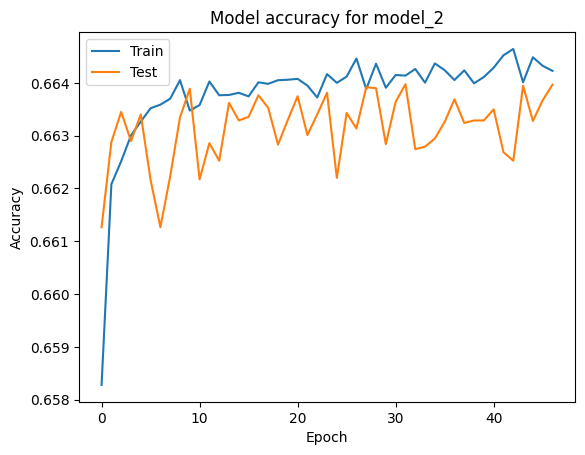

In [227]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model accuracy for model_2')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

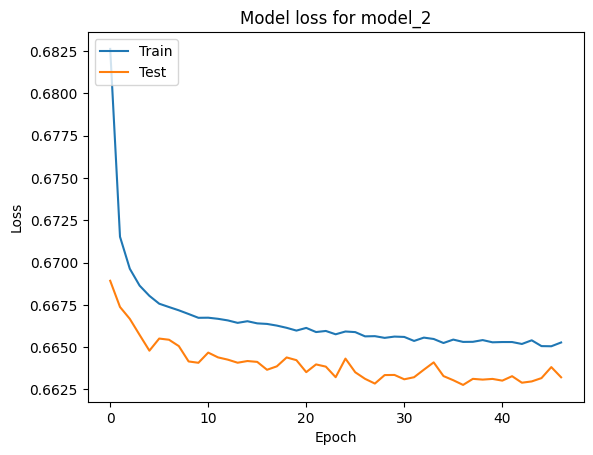

In [228]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss for model_2') 
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Overall ROC Curve for Feedforward Neural Network

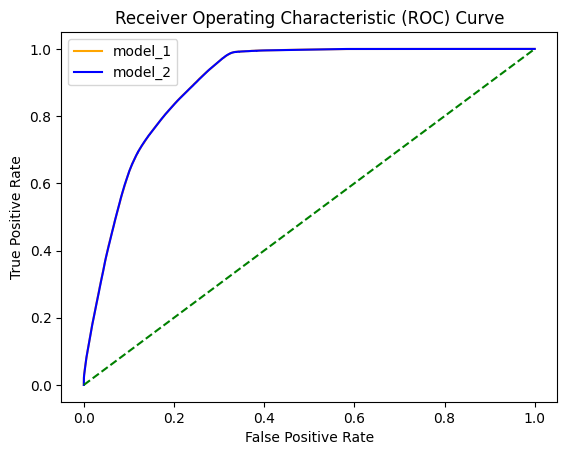

In [255]:
plt.plot(fpr_model_1, tpr_model_1, color='orange', label='model_1')
plt.plot(fpr_model_2, tpr_model_2, color='blue', label='model_2')
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

### Comparison of ROC Curve for the best model from NB, RF and FNN

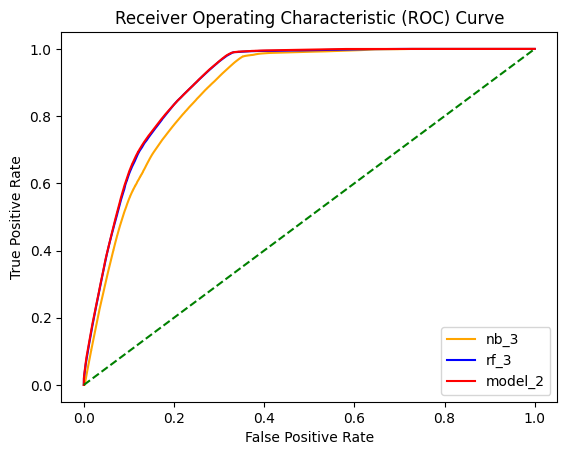

In [256]:
plt.plot(fpr_nb_3, tpr_nb_3, color='orange', label='nb_3')
plt.plot(fpr_rf_3, tpr_rf_3, color='blue', label='rf_3')
plt.plot(fpr_model_2, tpr_model_2, color='red', label='model_2')
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()